In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

# Sklearn algorithms
from sklearn import ensemble
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.compose import make_column_transformer
import lightgbm as lgb



C:\Users\malej\AppData\Local\Temp\ipykernel_11804\2553653015.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


### File and Data Field Descriptions
* train.csv - Personal records for about two-thirds (~8700) of the passengers, to be used as training data.
  * `PassengerId` - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
  * `HomePlanet` - The planet the passenger departed from, typically their planet of permanent residence.
  * `CryoSleep` - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
  * `Cabin` - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
  * `Destination` - The planet the passenger will be debarking to.
  * `Age` - The age of the passenger.
  * `VIP` - Whether the passenger has paid for special VIP service during the voyage.
  * `RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, `VRDeck` - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
  * `Name` - The first and last names of the passenger.
  * `Transported` - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.
* test.csv - Personal records for the remaining one-third (~4300) of the passengers, to be used as test data. Your task is to predict the value of `Transported` for the passengers in this set.
* sample_submission.csv - A submission file in the correct format.
  * `PassengerId` - Id for each passenger in the test set.
  * `Transported` - The target. For each passenger, predict either True or False.

### Firstly lets save requirements to txt

In [2]:
!pip freeze > data/requirements.txt

# data preview

In [2]:
#train_df = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
train_df = pd.read_csv('data/train.csv')

In [3]:
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [5]:
#test_df = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')
test_df = pd.read_csv('data/test.csv')

In [6]:
test_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [7]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


In [8]:
# = pd.read_csv('/kaggle/input/spaceship-titanic/sample_submission.csv')
submission = pd.read_csv('D:\SkillFactory\kaggle\data\sample_submission.csv')

<>:2: SyntaxWarning: invalid escape sequence '\S'
<>:2: SyntaxWarning: invalid escape sequence '\S'
C:\Users\malej\AppData\Local\Temp\ipykernel_11804\2007440257.py:2: SyntaxWarning: invalid escape sequence '\S'
  submission = pd.read_csv('D:\SkillFactory\kaggle\data\sample_submission.csv')


In [9]:
submission

,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,False
3,0021_01,False
4,0023_01,False
...,...,...
4272,9266_02,False
4273,9269_01,False
4274,9271_01,False
4275,9273_01,False


### duplicates and missing

In [10]:
print(train_df.isnull().sum(), '\n','-'* 50, '\n',  train_df.duplicated().value_counts())

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64 
 -------------------------------------------------- 
 False    8693
Name: count, dtype: int64


In [11]:
print(test_df.isnull().sum(), '\n','-'* 50, '\n',  test_df.duplicated().value_counts())

PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64 
 -------------------------------------------------- 
 False    4277
Name: count, dtype: int64


# EDA

### let's combine data sets for a more convenient working with visualisation and missing data

In [12]:
test_df['Transported'] = 0
train_df['mark'] = 0
test_df['mark'] = 1
df = pd.concat([train_df, test_df], ignore_index=True)

### explore the categorical features

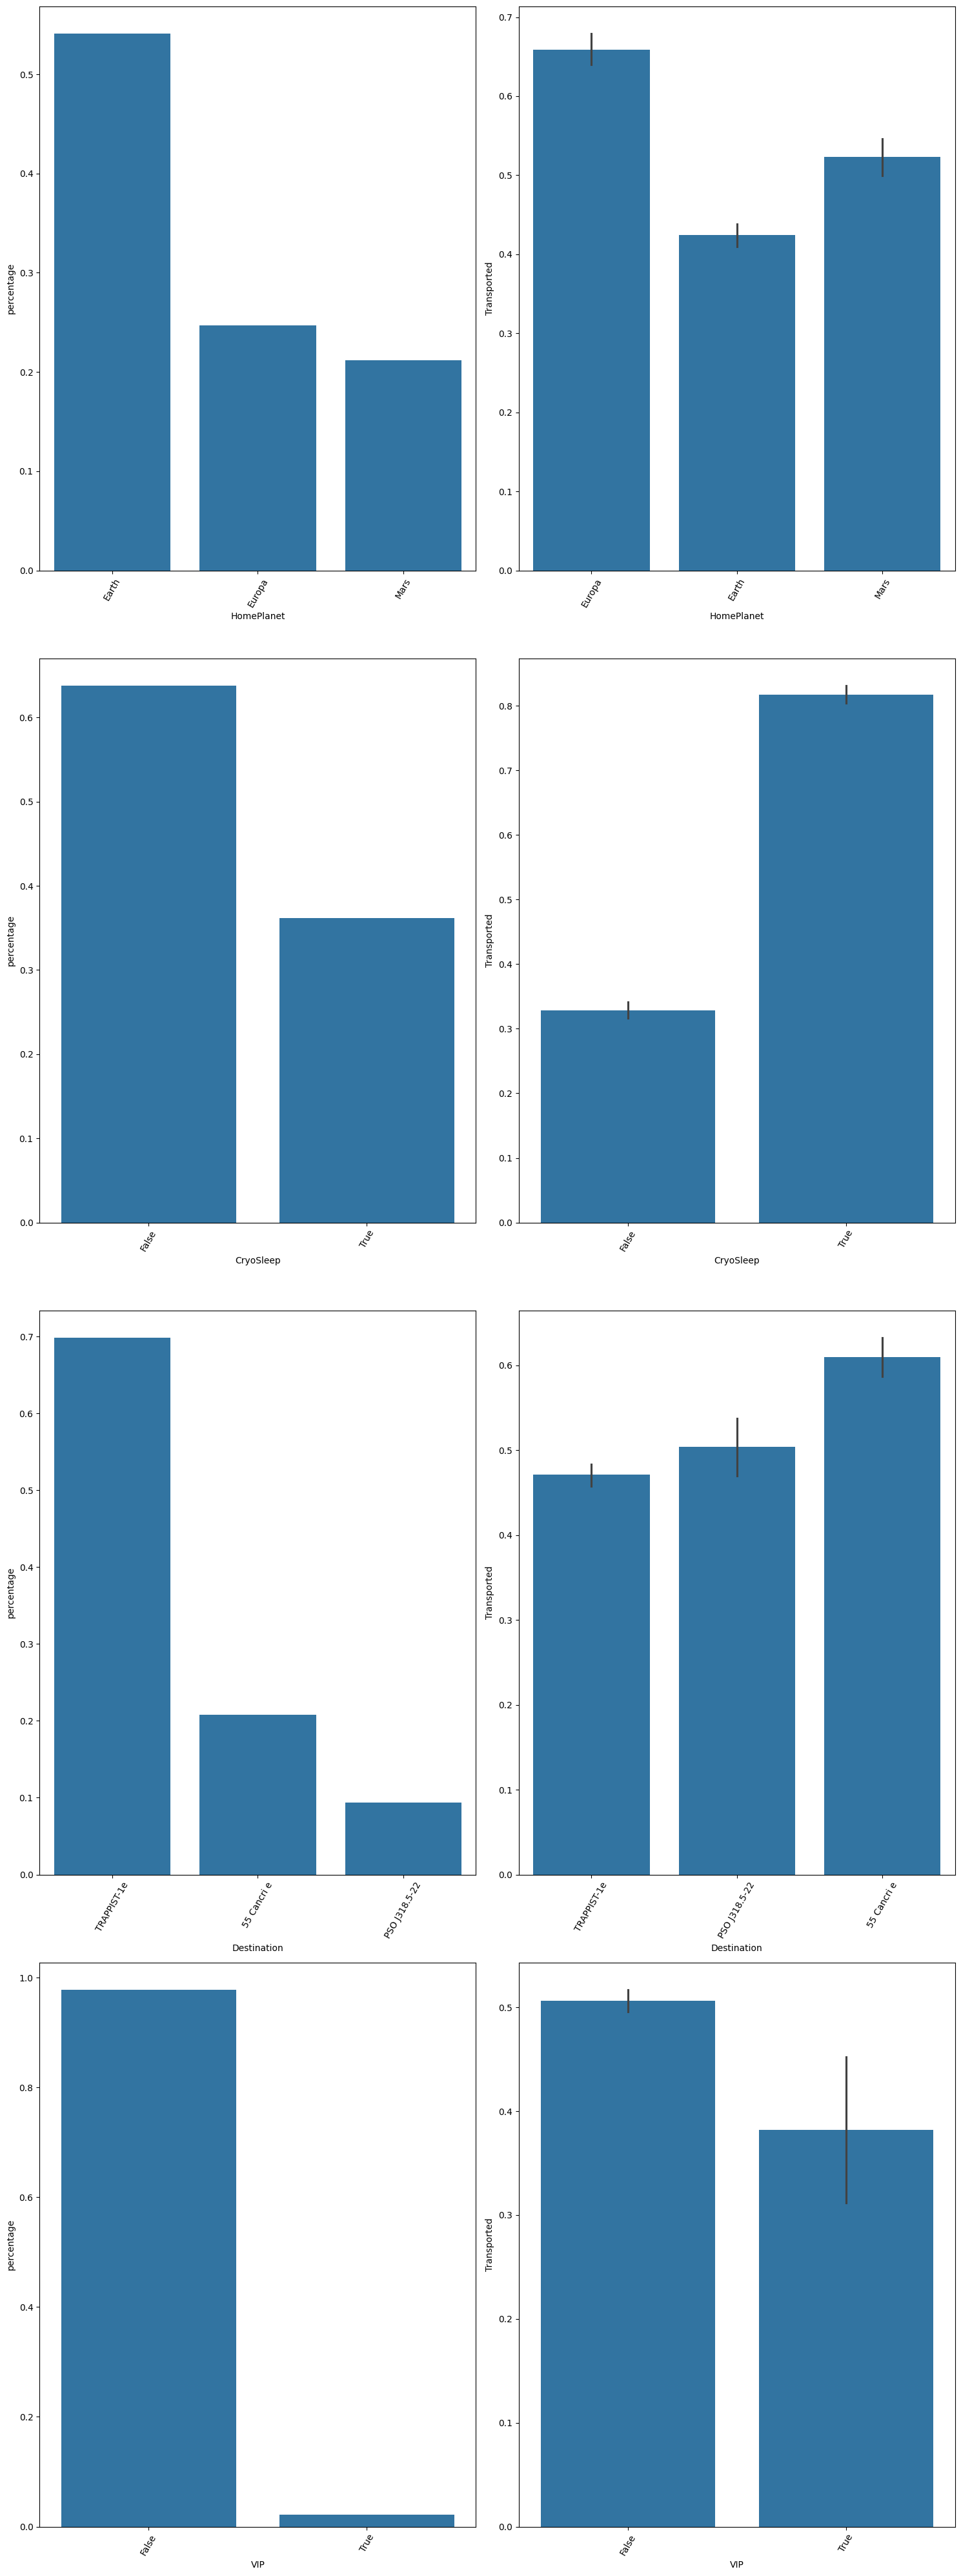

In [13]:
types = df.dtypes
cat_features = ['HomePlanet',
 'CryoSleep',
 'Destination',
 'VIP']

n = len(cat_features) #number of categorical features
fig, axes = plt.subplots(n, 2, figsize=(15, 40)) #figure+n*2 coordinate planes
#Creating a loop for all objects from the list of categorical objects
for i, feature in enumerate(cat_features):
    #Building a quantitative column for the proportion of each of the categories in the data
    count_data = (df[feature].value_counts(normalize=True)
                  .sort_values(ascending=False)
                  .rename('percentage')
                  .reset_index())
    count_barplot = sns.barplot(data=count_data, x=feature, y='percentage', ax=axes[i][0])
    count_barplot.xaxis.set_tick_params(rotation=60)
    #Building a histogram of people who have been transported
    mean_barplot = sns.barplot(data=train_df, x=feature, y='Transported', ax=axes[i][1])
    mean_barplot.xaxis.set_tick_params(rotation=60)
plt.tight_layout() #Alignment of graphs

## Feature engineering

### From  "Cabin" into "Deck", "Cabin_num" and "Side"

In [14]:
def deck(x):
    if isinstance(x,str):
        return x.split('/')[0]
    else:
        return x
       
def numm(x):
    if isinstance(x,str):
        return x.split('/')[1]
    else:
        return x
    
def side(x):
    if isinstance(x,str):
        return x.split('/')[2]
    else:
        return x
df['Deck'] = df['Cabin'].apply(deck)
df['Cabin_num'] = df['Cabin'].apply(numm)
df['Side'] = df['Cabin'].apply(side) 
df[['Cabin', 'Deck', 'Cabin_num', 'Side']]

# Drop column 'Cabin'
df = df.drop('Cabin', axis=1)

### From "PassengerId" into "Group" and "Identity"

In [15]:
df[['Group', 'Identity']] = df['PassengerId'].str.split(pat='_', expand=True)
# Drop column 'PassengerId'
df = df.drop('PassengerId', axis=1)

### From "Name" into "Frirst_name" and "Last_name"

In [16]:
df[['First_name', 'Last_name']] = df.Name.str.split(" ", expand=True)
# Drop column 'Name'
df = df.drop('Name', axis=1)

### Transforming all NAN value types into np.nan type

In [17]:
#NaN to np.nan
df = df.fillna(np.nan)

df[['Cabin_num','Group', 'Identity']] = df[['Cabin_num','Group', 'Identity']].astype('float32')

### Now we need to encode categorical features into numeric ones.

In [18]:
categorical = list(df.select_dtypes(['object']))
for i in categorical:
    print(df[i].value_counts(),'\n', '*'*20)
df = df.drop(['First_name', 'Last_name'], axis=1)
categorical = list(df.select_dtypes(['object']))

HomePlanet
Earth     6865
Europa    3133
Mars      2684
Name: count, dtype: int64 
 ********************
CryoSleep
False    8079
True     4581
Name: count, dtype: int64 
 ********************
Destination
TRAPPIST-1e      8871
55 Cancri e      2641
PSO J318.5-22    1184
Name: count, dtype: int64 
 ********************
VIP
False    12401
True       273
Name: count, dtype: int64 
 ********************
Deck
F    4239
G    3781
E    1323
B    1141
C    1102
D     720
A     354
T      11
Name: count, dtype: int64 
 ********************
Side
S    6381
P    6290
Name: count, dtype: int64 
 ********************
First_name
Luise     16
Idace     16
Ale       15
Thel      14
Kaye      14
          ..
Smark      1
Mureah     1
Grey       1
Pix        1
Perit      1
Name: count, Length: 2883, dtype: int64 
 ********************
Last_name
Buckentry      19
Belley         19
Hinglendez     18
Fowlesterez    18
Casonston      18
               ..
Cabraseed       1
Miste           1
Imotive         1
G

### We will fit the encoders to training data and transform to test data

In [19]:
X_train = df[df['mark'] == 0]
y_train = X_train['Transported']
X_test = df[df['mark'] == 1]

X_train = X_train.drop('Transported', axis=1)
X_test = X_test.drop('Transported', axis=1)

### Convert categorical data into numerical features

In [20]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan) 


X_train[categorical] = ordinal_encoder.fit_transform(X_train[categorical]) 
X_test[categorical] = ordinal_encoder.transform(X_test[categorical])

# check dtypes for each column and correct where necessary 
print(X_train.info(), y_train.info(), X_test.info(), sep = '\n\n')
print(X_train.describe(), y_train.describe(), X_test.describe(), sep = '\n\n')

<class 'pandas.core.frame.DataFrame'>
Index: 8693 entries, 0 to 8692
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8492 non-null   float64
 1   CryoSleep     8476 non-null   float64
 2   Destination   8511 non-null   float64
 3   Age           8514 non-null   float64
 4   VIP           8490 non-null   float64
 5   RoomService   8512 non-null   float64
 6   FoodCourt     8510 non-null   float64
 7   ShoppingMall  8485 non-null   float64
 8   Spa           8510 non-null   float64
 9   VRDeck        8505 non-null   float64
 10  mark          8693 non-null   int64  
 11  Deck          8494 non-null   float64
 12  Cabin_num     8494 non-null   float32
 13  Side          8494 non-null   float64
 14  Group         8693 non-null   float32
 15  Identity      8693 non-null   float32
dtypes: float32(3), float64(12), int64(1)
memory usage: 1.0 MB
<class 'pandas.core.series.Series'>
Index: 8693 entries, 0 to

### Using KNN Imputer to impute missing values 

In [21]:
# ensure all NA values are represented uniformluy as np.nan 
X_train = X_train.fillna(np.nan)
X_test = X_test.fillna(np.nan) 

# Instantiate KNNImputer using default 5 neighbors 
imputer = KNNImputer(n_neighbors=5) 



X_train.loc[:] = imputer.fit_transform(X_train) 
X_test.loc[:] = imputer.transform(X_test) 

C:\Users\malej\AppData\Local\Temp\ipykernel_11804\434091889.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[   0.    0.    0. ... 1500.  608.  608.]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  X_train.loc[:] = imputer.fit_transform(X_train)
C:\Users\malej\AppData\Local\Temp\ipykernel_11804\434091889.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[   3.    4.    0. ...  296.  297. 1498.]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  X_test.loc[:] = imputer.transform(X_test)


### Transforming Categorical features using OneHotEncoder 

In [22]:

print('Before OHE', X_train.shape, X_test.shape, sep='\n')
onehot = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False) 
onehot = make_column_transformer((onehot, categorical), remainder='passthrough')
X_train = onehot.fit_transform(X_train)
X_test = onehot.transform(X_test) 
print('After OHE', X_train.shape, X_test.shape, sep='\n')

Before OHE
(8693, 16)
(4277, 16)
After OHE
(8693, 70)
(4277, 70)


### Transforming the features

In [23]:
scaler = RobustScaler(with_centering=True)
X_train = scaler.fit_transform(X_train) 
X_test = scaler.transform(X_test) 


### Creating training and test split to evaluate model performances

In [24]:
X_train, X_test, Y_train, Y_test = train_test_split(X_train, y_train, test_size = 0.25, random_state =42)

### Use Gradient Boosting Classifier

In [25]:
clf = lgb.LGBMClassifier()
clf.fit(X_train, Y_train)

[LightGBM] [Info] Number of positive: 3286, number of negative: 3233
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000611 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1943
[LightGBM] [Info] Number of data points in the train set: 6519, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504065 -> initscore=0.016261
[LightGBM] [Info] Start training from score 0.016261


LGBMClassifier()

In [26]:
y_pred=clf.predict(X_test)

In [27]:
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(y_pred, Y_test)
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(Y_test, y_pred)))

LightGBM Model accuracy score: 0.8008
